# Sentiment Analysis

### Objective: Build a deep learning model using bert embedding(Text classification). 

#### Attribute Explanation:

Original Text: Original text of the chat <br>
Relevant Text: Key sentence of the original text <br>
Recitified_Score_2:ignore <br>
Entity_name: sentence belong to which entity <br>
DM_Score:4 classes(1-negative,2-neutral,3-positive,4-extreme positive) <br>
Neutral_Non_Neutral-Neutral or non-neutral <br>

### 1. Data Loading

In [61]:
# downloading nltk stopwords
import nltk
nltk.download('stopwords')
# importing the relevant libraries
import time

starting_time=time.time()
import nltk
nltk.download('stopwords')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
stop_words = stopwords.words('english')
stop_words.extend(['hi', 'Hi', 'Hello', 'hello', 'Howdy', 'howdy'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
## Loading the data into python
raw_data = pd.read_excel("Neutral_Non_Neutral_Training.xlsx")

### 2. Exploratory Data Analysis

In [63]:
## Information of the data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7491 entries, 0 to 7490
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Filename             7491 non-null   object
 1   Original Text        7491 non-null   object
 2   Relevant_Text        7491 non-null   object
 3   Recitified_Score_2   7491 non-null   int64 
 4   Entity_name          7491 non-null   object
 5   DM_Score             7491 non-null   int64 
 6   Neutral_Non_Neutral  7491 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 409.8+ KB


There are total 7491 observations and 7 features in this data set. There are 4 columns of object(string) data type and 3 of them of integer. <br> 
As, we can see no null or missing values in this data set.



In [64]:
# displaying first few records
raw_data.head()

,Filename,Original Text,Relevant_Text,Recitified_Score_2,Entity_name,DM_Score,Neutral_Non_Neutral
0,Final_Prediction_Entity_Extraction_8001.csv,"In that case, I will recommend you sign a long...",sign a long term lease,4,renewed,4,1
1,Final_Prediction_Entity_Extraction_8501.csv,So personally I love the apartment the buildin...,all the office people,2,management,2,2
2,Final_Prediction_Entity_Extraction_1751.csv,And yes I’m in the B2 floor plan,I’m in the B2 floor plan,2,unit_features,2,2
3,Final_Prediction_Entity_Extraction_1251.csv,I love living in this community.,I love living in this community,4,community,4,1
4,Final_Prediction_Entity_Extraction_8251.csv,I would say they are comparable to gyms at hig...,I would say they are comparable to gyms,3,fitness_center,3,1


In [65]:
## Summary statistics of numeric fields
raw_data.describe()

,Recitified_Score_2,DM_Score,Neutral_Non_Neutral
count,7491.000000,7491.000000,7491.000000
mean,2.887999,2.920972,1.252570
std,1.094411,1.019386,0.434515
min,0.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000
50%,3.000000,3.000000,1.000000
75%,4.000000,4.000000,2.000000
max,4.000000,4.000000,2.000000


Looking at the quintiles we can say that these columns hold discrete values. (As has been instructed, Rectified_Score_2 can be ignored from further analysis)

In [66]:
total_files_used = raw_data['Filename'].nunique()
if total_files_used == raw_data.shape[0]:
    print("Each record is captured from a unique file.")
else:
    print(f"Data is extracted from {total_files_used} files in this dataset.")

Data is extracted from 38 files in this dataset.


In [67]:
# DM_Score:4 classes(1-negative,2-neutral,3-positive,4-extreme positive)
# creating a new column
conditions = [(raw_data['DM_Score'] == 1),
             (raw_data['DM_Score'] == 2),
             (raw_data['DM_Score'] == 3),
             (raw_data['DM_Score'] == 4),]
values = ["negative", "neutral", "positive", "extreme positive"]
raw_data["Sentiment"] = np.select(conditions, values)
raw_data["Sentiment"].value_counts()

extreme positive    2846
positive            1980
neutral             1892
negative             773
Name: Sentiment, dtype: int64

In [68]:
raw_data["Sentiment"].value_counts(normalize=True)

extreme positive    0.379923
positive            0.264317
neutral             0.252570
negative            0.103190
Name: Sentiment, dtype: float64

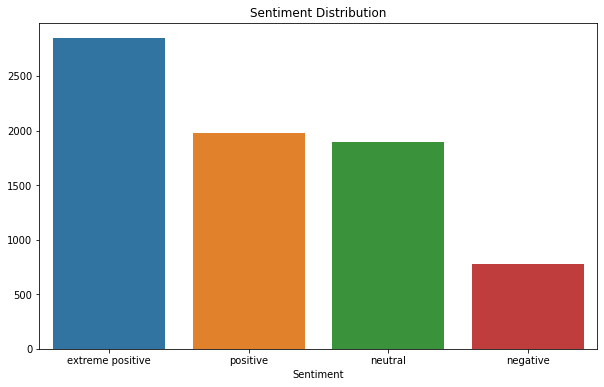

In [69]:
# plot sentiment distribution
plt.figure(figsize=(10,6))
sns.countplot(x = "Sentiment", data = raw_data,
              
             order=raw_data['Sentiment'].value_counts().index);
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("")
plt.show()

This plot depicts sentiment distribution. We can see that more than 50% of observations comprise of positive sentiments (including extreme positives). And only 10% of the observations are of negative sentiment. As we can see, data is imbalanced.

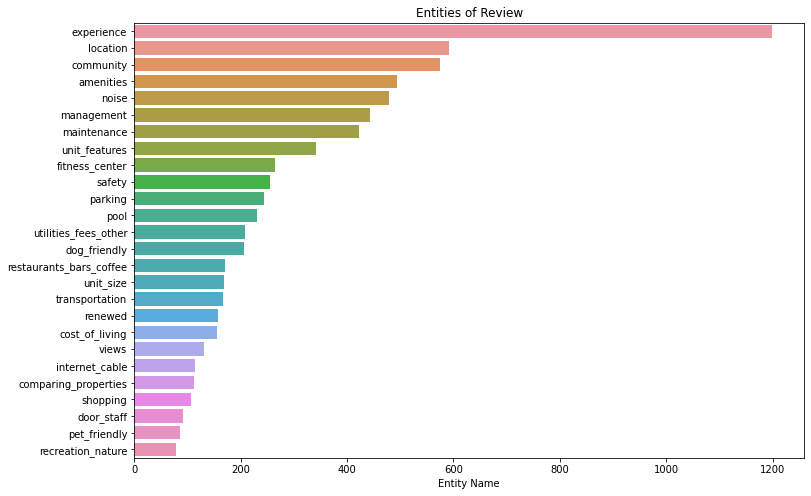

In [70]:
# plot entitites
plt.figure(figsize=(12,8))
entities = raw_data['Entity_name'].value_counts()
sns.barplot(x = entities.values, y = entities.index)
plt.title("Entities of Review")
plt.xlabel("Entity Name")
plt.ylabel("")
plt.show()

This plot shows that consumers care more about experience, location, ambience more than anything else.

In [71]:
# function for basic cleansing
def clean_text(text):    
    """Peforms basic cleansing steps on text feature.     
    # Arguments         
        text: list, sample text   
        Returns: clean text
    """
    text = re.sub('\s+', ' ', str(text))     # remove new line characters       
    text = re.sub("\'", "", str(text)) # remove single characters 
    text = re.sub('[^a-zA-Z #+_]', '', text)          # removes special characters
    text = text.lower()          # convert to lowercase to maintain consistency
    text = ' '.join(word for word in text.split() if word not in stop_words) # remove stop words   
    return text  

In [72]:
clean_data = raw_data.copy()
clean_data['modified_text'] = clean_data["Original Text"].apply(clean_text)

In [73]:
max_modified_text_len = int(clean_data["modified_text"].str.encode(encoding='utf-8').str.len().max())
min_modified_text_len = int(clean_data["modified_text"].str.encode(encoding='utf-8').str.len().min())
print(max_modified_text_len)
print(min_modified_text_len)

481
0


Minimum length of cleansed text is zero for some of the records. They may not have any meaningful information. We can explore what texts have length less than or equal to 3 after cleansing.

In [74]:
filter_len = clean_data["modified_text"].str.encode(encoding='utf-8').str.len()
clean_data[["modified_text","Original Text"]][filter_len<=3]

,modified_text,Original Text
36,bad,It’s not that bad
213,,I am here now.
2013,say,All they can do is say no.
2825,bad,So all in all not bad
3340,bad,Hi it’s not that bad.
6607,spa,And it has spa
6642,bed,I have a 1 bed


In [75]:
# length distribution
def plot_length_distribution(text):     
    """Plots the sample length distribution.     
    # Arguments         
        text: list, sample text   
        Returns: plot of length distribution
    """
    plt.figure(figsize=(12,6))
    plt.hist([len(s) for s in text], 30)
    plt.xlabel('Length of a text record')     
    plt.ylabel('Number of Records')     
    plt.title('Text length distribution')    
    plt.show()

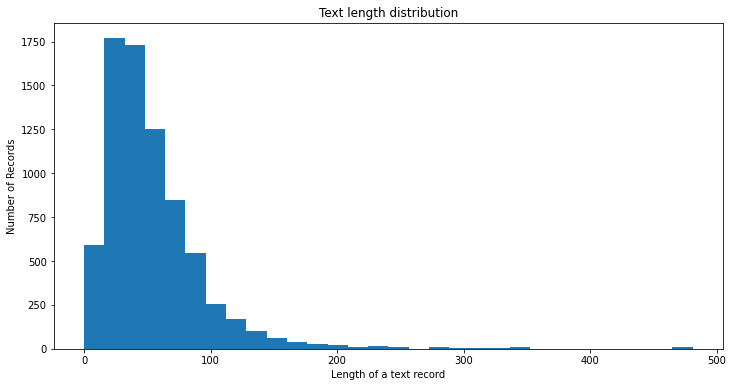

In [76]:
plot_length_distribution(clean_data["modified_text"])

There are some records/texts with length more than 300. Let us filter to see how many records have more than 250 length

In [77]:
filter_len = clean_data["modified_text"].str.encode(encoding='utf-8').str.len()
clean_data[["modified_text"]][filter_len>=250].count()

modified_text    49
dtype: int64

In [78]:
clean_data["Relevant_Text"][filter_len>=250]
clean_data["Relevant_Text"][filter_len>=250].count()

49

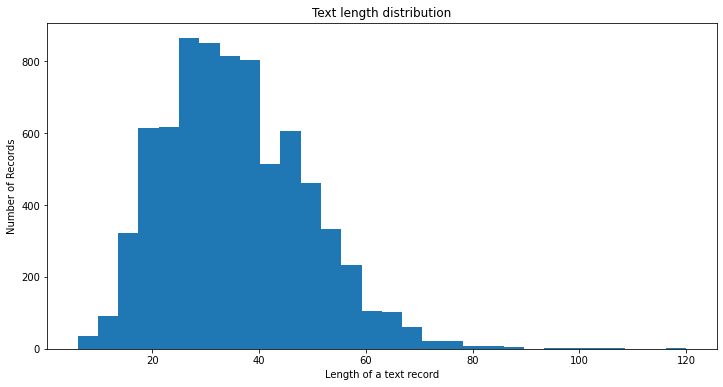

In [79]:
# plotting relevant text without any cleansing
plot_length_distribution(clean_data["Relevant_Text"])

Relevant text seems to be normalized with not so many extreme values.

In [80]:
clean_data['clean_relevant_text'] = clean_data["Relevant_Text"].apply(clean_text)

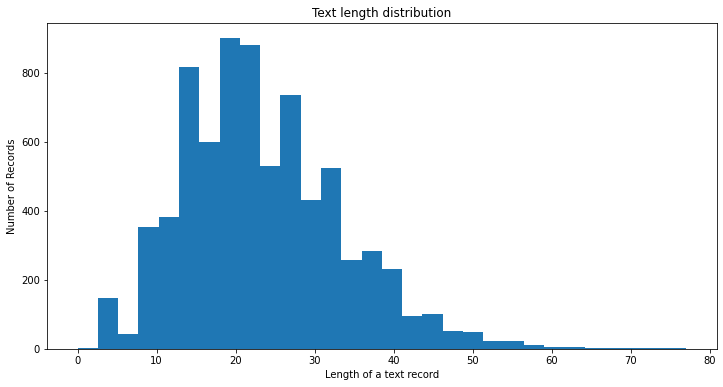

In [81]:
plot_length_distribution(clean_data["clean_relevant_text"])

In [82]:
clean_data[["clean_relevant_text","Relevant_Text", "DM_Score"]].head(10)

,clean_relevant_text,Relevant_Text,DM_Score
0,sign long term lease,sign a long term lease,4
1,office people,all the office people,2
2,im b floor plan,I’m in the B2 floor plan,2
3,love living community,I love living in this community,4
4,would say comparable gyms,I would say they are comparable to gyms,3
5,friends didnt like,My friends didn’t like that,1
6,really good monitoring pool,They are really good about monitoring the pool,4
7,cant beat location either,Can’t beat the location either,4
8,absolutely love living,I absolutely love living at 1140,4
9,love,I love it,4


In [83]:
clean_data["clean_relevant_text"][filter_len<=2].count()

1

In [84]:
# drop rows with nulls
clean_data.drop(clean_data[clean_data["clean_relevant_text"].map(len)<=2].index , inplace = True)
#raw_data.drop(raw_data[raw_data["clean_relevant_text"].map(len)<=2].index , inplace = True)

In [85]:
clean_data["clean_relevant_text"][filter_len<=2].count()

0

### 3. Model Building

#### As we have seen in EDA, entities are also giving us some information about sentiments. This feature may be clubbed with text feature to enhance model performance. Two approaches could be tried:
1. Use text feature 'relevant text' without entity and check model performance
2. Use text feature 'relevant text' along with entity and check model performance

In [86]:

clean_data['clean_relevant_text'] = clean_data['clean_relevant_text'] +" " + clean_data ["Entity_name"]

In [87]:
dataset = clean_data[['clean_relevant_text', 'DM_Score']]
dataset.head()

,clean_relevant_text,DM_Score
0,sign long term lease renewed,4
1,office people management,2
2,im b floor plan unit_features,2
3,love living community community,4
4,would say comparable gyms fitness_center,3


In [88]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 30
# This is fixed.
EMBEDDING_DIM = 100


In [89]:
## Tokenizing and checking the shapes of tensor(for testing purposes)

X = tokenizer.texts_to_sequences(dataset['clean_relevant_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)



Y = pd.get_dummies(dataset['DM_Score']).values
print('Shape of DM_Score tensor:', Y.shape)


Shape of data tensor: (7490, 30)
Shape of DM_Score tensor: (7490, 4)


In [90]:
## Splitting data set into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=dataset[['DM_Score']], test_size=0.30, random_state=42)   

## Checking the shape of the train and test set(For testing purposes) 

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

print("input length is  :", X.shape[1])


(5243, 30) (5243, 4)
(2247, 30) (2247, 4)
input length is  : 30


In [91]:
## Generating model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 180,804
Trainable params: 180,804
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
## Training model

epochs = 10
batch_size = 32

#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,\
 #                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]) 

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Epoch 1/10
148/148 [==============================] - 10s 69ms/step - loss: 1.1782 - accuracy: 0.4627 - val_loss: 0.9533 - val_accuracy: 0.6133
Epoch 2/10
148/148 [==============================] - 10s 67ms/step - loss: 0.8804 - accuracy: 0.6439 - val_loss: 0.8222 - val_accuracy: 0.6743
Epoch 3/10
148/148 [==============================] - 10s 67ms/step - loss: 0.7505 - accuracy: 0.7009 - val_loss: 0.7924 - val_accuracy: 0.6876
Epoch 4/10
148/148 [==============================] - 10s 67ms/step - loss: 0.6881 - accuracy: 0.7315 - val_loss: 0.8137 - val_accuracy: 0.6743
Epoch 5/10
148/148 [==============================] - 10s 66ms/step - loss: 0.6430 - accuracy: 0.7558 - val_loss: 0.8289 - val_accuracy: 0.6705
Epoch 6/10
148/148 [==============================] - 10s 67ms/step - loss: 0.6123 - accuracy: 0.7611 - val_loss: 0.8218 - val_accuracy: 0.6686
Epoch 7/10
148/148 [==============================] - 10s 68ms/step - loss: 0.5897 - accuracy: 0.7747 - val_loss: 0.8662 - val_accuracy:

### 4. Model Evaluation

In [93]:
### Evaluating model by predicting on test data
y_pred = model.predict(X_test)
y_actual = []
y_pred_classes = []
y_pred_prob = []
Y_classes=dataset["DM_Score"].unique().tolist()
for row in range(len(y_pred)):
    y_actual.append(Y_classes[np.argmax(y_test[row])])
    y_pred_classes.append(Y_classes[np.argmax(y_pred[row])])
    y_pred_prob.append(np.max(y_pred[row]))


## 5. Classification Matrix

In [94]:
print(classification_report(y_actual, y_pred_classes, target_names=clean_data.Sentiment.unique()))

                  precision    recall  f1-score   support

extreme positive       0.79      0.85      0.82       854
         neutral       0.66      0.72      0.69       567
        positive       0.58      0.53      0.55       594
        negative       0.55      0.39      0.46       232

        accuracy                           0.69      2247
       macro avg       0.64      0.62      0.63      2247
    weighted avg       0.68      0.69      0.68      2247



### 6. Confusion Matrix

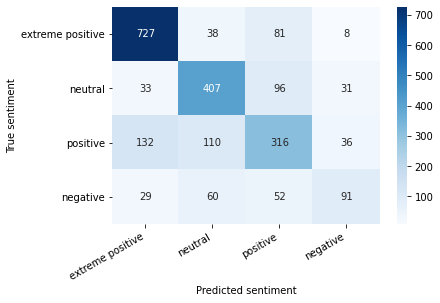

In [95]:

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_actual, y_pred_classes)
df_cm = pd.DataFrame(cm, index=clean_data.Sentiment.unique(), columns=clean_data.Sentiment.unique())
show_confusion_matrix(df_cm)

### 7. Conclusion

With just few thousand records, we are able to get train and test accuracy of 79% , 68% respectively. LSTM deep learning model is fit using keras tokenizer here instead of bert. I also, tried using bert embedding instead of keras tokenizer but that gave very poor performance approx. 44% accuracy on training. This could further be fined tune with respect to relevant hyper parameters and improved.